In [1]:
# Copyright (c) 2015, Cordoba Astronomical Observatory.  All rights reserved.
#                    Unauthorized reproduction prohibited. 
# NAME:
#        aligo-vs-glade
# PURPOSE:
#        "Toritos Scheduler White catalog loader
#
# CATEGORY:
#	     Program.
#
# COMPILING SEQUENCE:
# 	     ipython notebook
#
# INPUTS:
#
#
# MODIFICATION HISTORY:
# 	Written by:	Mariano Dominguez, July 2015
#   from previuos version using White Catalog January 2014.
#   Any inquirities send an e-mail to mardom@oac.uncor.edu
#

# Modified by Bruno Sanchez, October 2015

In [2]:
# Global paths and constants
data_path = '.'
# Load useful packages
import os
import numpy as np
import math as m

import matplotlib.pyplot as plt

from astropy.io import ascii, fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u

import seaborn
%matplotlib inline

/home/bruno/.virtualenvs/alertreport/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
#graphic output directory.
import conf2MASS as cf

plots = cf.plots
if not os.path.isdir(plots):
    os.mkdir(plots)

In [4]:
import time
print (time.strftime("%d/%m/%Y"))
print (time.strftime("%H:%M:%S"))

macon_date=time.strftime("%Y/%m/%d %H:%M:%S")

10/01/2016
20:48:33


In [5]:
import ephem
obs = ephem.Observer()
obs.lat = cf.obs_lat
obs.lon = cf.obs_lon
obs.elevation = cf.obs_elevation

print obs
# extracting the correct values. WEIRD
print float(ephem.degrees(obs.lon*180./m.pi)), float(ephem.degrees(obs.lat*180./m.pi))

<ephem.Observer date='2016/1/10 23:48:34' epoch='2000/1/1 12:00:00' lon='-64:28:48.0' lat='-31:34:48.0' elevation=1350.0m horizon=0:00:00.0 temp=15.0C pressure=1010.0mBar>
-64.48 -31.58


In [6]:
sun = ephem.Sun()
sun.compute(obs)
print sun.a_ra, sun.a_dec
sun_coords = SkyCoord(str(sun.a_ra), str(sun.a_dec), unit=(u.hourangle, u.deg))

print "Sun coordinates are = {}".format(sun_coords.to_string('hmsdms'))

moon = ephem.Moon()
moon.compute(obs)
moon_coords = SkyCoord(str(moon.a_ra), str(moon.a_dec), unit=(u.hourangle, u.deg))

print "Moon coordinates are = {}".format(moon_coords.to_string('hmsdms'))

19:26:20.54 -21:57:16.9
Sun coordinates are = 19h26m20.54s -21d57m16.9s
Moon coordinates are = 20h12m19.61s -15d53m06.7s


This part intends to calculate the rising and setting of the sun at the given date and at Macon.
Since the big errors and differences for the actual setting and rising times of the sun here, we don't trust it at all. Anyway it is not used for any kind of calculation.

In [7]:
sunrise, sunset = obs.next_rising(sun), obs.next_setting(sun)

print "The time of sunset is {}, \nand the time of sunrise is {}".format(sunset, sunrise)

The time of sunset is 2016/1/11 23:27:19, 
and the time of sunrise is 2016/1/11 09:23:50


In [8]:
# at sunset 
alpha_zenith_sunset = sun_coords.ra + 105.*u.deg
alpha_observable_min = alpha_zenith_sunset - 40.*u.deg

In [9]:
# at sunrise
alpha_zenith_sunrise = sun_coords.ra - 105.*u.deg
alpha_observable_max = alpha_zenith_sunrise + 40.*u.deg

In [10]:
print alpha_observable_min.hour, alpha_observable_max.hour

23.7723722222 15.1057055556


In [12]:
cat = fits.open(cf.catalog)
cat = Table(cat[1].data)

In [13]:
cat

TMID,RA,DEC,GLON,GLAT,MKC,MHC,MJC,MKTC,MHTC,MJTC,EKC,EHC,EJC,EKTC,EHTC,EJTC,EBV,RISO,RTOT,BA,FLAGS,TYPE,TYPESRC,V,EV,VCAT,VSRC,CATID
string128,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,string32,string40,string16,int32,int16,string8,string152,string224
00424433+4116074,10.6847,41.2687,121.174,-21.5732,0.797,0.929,1.552,0.743,0.881,1.497,0.016,0.016,0.015,0.017,0.017,0.016,0.683,3.208,3.491,0.473,Z111,3A2s,ZC,-300,4,N,1991RC3.9.C...0000d,MESSIER_031
00473313-2517196,11.8881,-25.2888,97.363,-87.9645,3.815,4.132,4.858,3.765,4.077,4.798,0.016,0.015,0.015,0.017,0.016,0.016,0.019,2.799,2.965,0.264,Z111,5X_s,ZC,243,2,N,2004AJ....128...16K,NGC_0253
09553318+6903549,148.888,69.0653,142.092,40.9002,3.898,4.131,4.784,3.803,4.043,4.69,0.016,0.016,0.015,0.018,0.018,0.016,0.08,2.688,2.878,0.517,Z111,2A2s,ZC,-34,4,N,1991RC3.9.C...0000d,MESSIER_081
13252775-4301073,201.366,-43.0187,309.516,19.4176,3.948,4.244,4.931,3.901,4.203,4.876,0.015,0.016,0.015,0.016,0.017,0.016,0.115,2.445,2.613,0.957,Z111,-2__P,ZC,547,5,N,1978PASP...90..237G,NGC_5128
13052727-4928044,196.364,-49.4679,305.272,13.3402,4.471,4.79,5.508,4.421,4.735,5.444,0.016,0.016,0.015,0.017,0.017,0.016,0.176,2.627,2.772,0.308,Z111,6B_s,ZC,563,3,N,2004AJ....128...16K,NGC_4945
01335090+3039357,23.4621,30.6599,133.61,-31.3308,4.477,4.697,5.346,4.087,4.329,5.003,0.02,0.018,0.017,0.044,0.038,0.029,0.041,2.699,3.032,0.792,Z111,5A4s,ZC,-179,3,N,1991RC3.9.C...0000d,MESSIER_033
09555243+6940469,148.968,69.6797,141.41,40.5671,4.636,5.003,5.744,4.61,4.973,5.704,0.015,0.015,0.015,0.015,0.015,0.015,0.156,2.357,2.542,0.396,Z111,0,ZC,203,4,N,1991RC3.9.C...0000d,MESSIER_082
03464851+6805459,56.7021,68.0961,138.173,10.58,4.682,4.952,5.494,4.362,4.682,5.169,0.02,0.019,0.018,0.043,0.04,0.033,0.558,2.571,2.876,0.858,Z111,6X2T,ZC,31,3,N,1999PASP..111..438F,IC_0342
13370091-2951567,204.254,-29.8658,314.584,31.9727,4.721,4.951,5.594,4.595,4.832,5.48,0.017,0.016,0.016,0.025,0.019,0.018,0.067,2.495,2.709,0.825,Z111,5X2s,ZC,513,2,N,2004AJ....128...16K,MESSIER_083


From here and in the future the Hubble *constant* is assumed to be 70 Mpc/km/s

In [14]:
dist_lim = 300.
H_0 = 70

cat['Dist'] = cat['V']/H_0
horizon = cat['Dist']  < dist_lim      # Distance cut
far =  cat['Dist'] > 50. 
lim_dec = cat['DEC']< 30.          # Declination cut
alfa_min = cat['RA'] >  float(alpha_observable_min.degree)       # Alpha cut 
alfa_max = cat['RA'] <= float(alpha_observable_max.degree)

In [15]:
if alpha_observable_max.hour%24. > alpha_observable_min.hour%24.:
    sample = cat[horizon & far & lim_dec & (alfa_min & alfa_max)]
else:
    sample = cat[horizon & far & lim_dec & (alfa_min | alfa_max)]

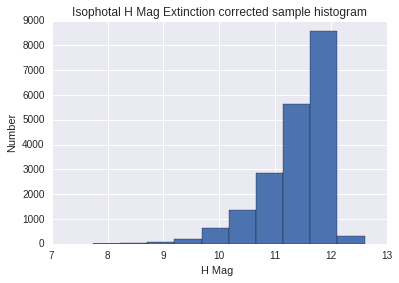

In [16]:
plt.hist(sample['MHC'])
plt.xlabel('H Mag ')
plt.ylabel('Number')
plt.title('Isophotal H Mag Extinction corrected sample histogram')

plt.savefig(os.path.join(plots, 'hmag_sample_histogram.png'), dpi=300)

plt.show()

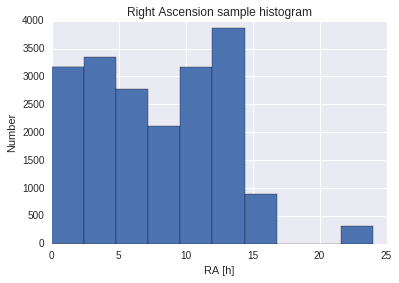

In [17]:
plt.hist(sample['RA']/15.)
plt.xlabel('RA [h]')
plt.ylabel('Number')
plt.title('Right Ascension sample histogram')

plt.savefig(os.path.join(plots, 'RA_sample_histogram.png'), dpi=300)

plt.show()

115.0 -31.58


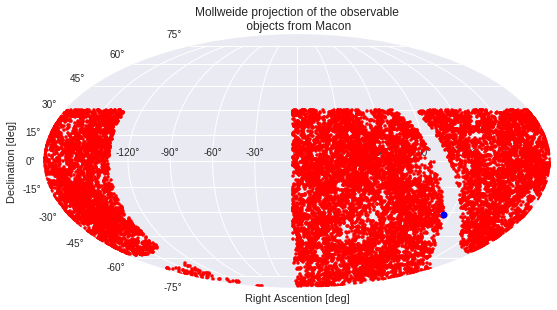

In [18]:
plt.figure(figsize=(10,10))
plt.subplot(211, projection="mollweide")
deg2rad=np.pi/180.

x = sample['RA']*deg2rad
xg = []
for ax in x:
    if ax > m.pi:
        ax = ax - 2*m.pi
    xg.append(ax)
    
yg = sample['DEC']*deg2rad


ramax = alpha_observable_max.hour
if alpha_observable_min.hour > 12. : 
    ramin = alpha_observable_min.hour - 24.
else:
    ramin = alpha_observable_min.hour
    
mean_zenith_ra = ((ramax-ramin)*15./2.)

zenith_dec = float(ephem.degrees(obs.lat*180./m.pi))

print mean_zenith_ra, zenith_dec

# we should avoid the galactic plane
plt.plot(xg,yg, "r.")

plt.plot(mean_zenith_ra*deg2rad, zenith_dec*deg2rad, 'bo' )
plt.grid(True)
plt.title("Mollweide projection of the observable\n objects from Macon")
plt.xlabel("Right Ascention [deg]")
plt.ylabel("Declination [deg]")
plt.savefig(os.path.join(plots, 'radec_mollweide_sample.png'), dpi=300)
plt.show()

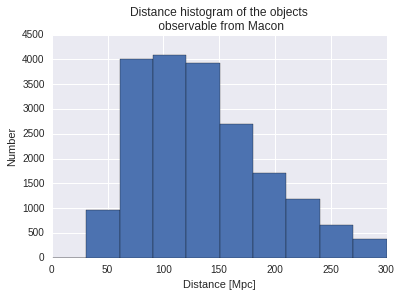

In [19]:
plt.hist(sample['Dist'], range=[1,dist_lim])
plt.title('Distance histogram of the objects\n observable from Macon')

plt.xlabel('Distance [Mpc]')
plt.ylabel('Number')

plt.savefig(os.path.join(plots, 'distance_histogram_sample.png'), dpi=300)

plt.show()

In [20]:
import healpy as hp

In [21]:
skymap = cf.skymap 

In [22]:
aligo_alert_data_file=os.path.join(data_path,skymap)
NSIDE=512 #2048
aligo_banana = hp.read_map(aligo_alert_data_file)

NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [23]:
from astropy.io import fits
hdr1 = fits.getheader(aligo_alert_data_file)

In [24]:
hdr1

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2015-12-26T09:40:21' / file creation date (YYYY-MM-DDThh:mm:ss UT)   

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


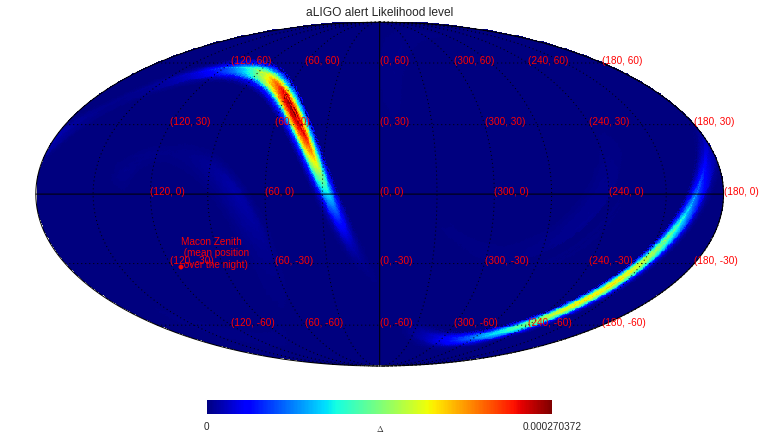

In [25]:
# plot the banana map
fig = plt.figure(2, figsize=(10, 10))
hp.mollview(aligo_banana, title='aLIGO alert Likelihood level', flip="astro",
            unit='$\Delta$', fig=2)
fig.axes[1].texts[0].set_fontsize(8)

hp.projscatter(mean_zenith_ra, zenith_dec
               , lonlat=True, color="red")
hp.projtext(mean_zenith_ra, zenith_dec,
            'Macon Zenith\n (mean position\n over the night)', lonlat=True, color="red")
for ra in range(0,360,60):
    for dec in range(-60,90,30):
        hp.projtext(ra,dec,'({}, {})'.format(ra,dec), lonlat=True, color='red')

hp.graticule()

plt.savefig(os.path.join(plots, 'allsky_likelihoodmap.png'), dpi=300)
plt.show()

50.5891087121 129.410891288 -39.4108912879 39.4108912879
The interval between parallels is 10 deg 0.00'.
The interval between meridians is 4 deg 0.00'.


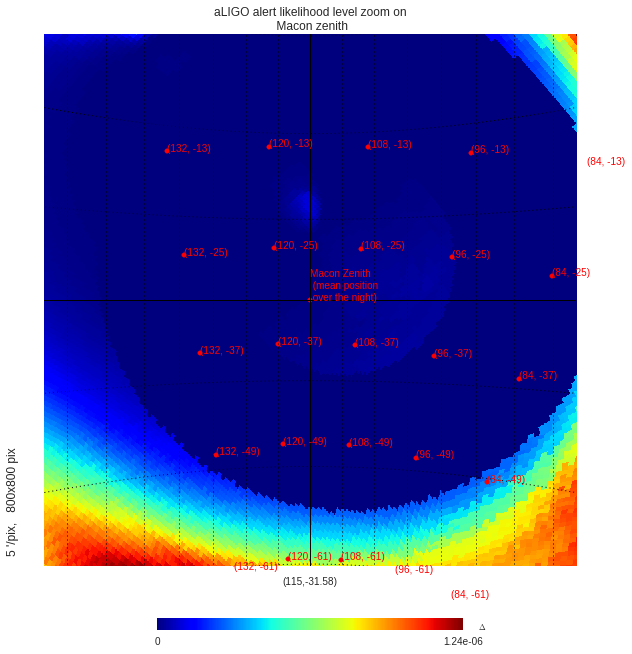

In [26]:
# plot the banana map
fig = plt.figure(2, figsize=(10, 10))
rot=[mean_zenith_ra, zenith_dec]
hp.gnomview(aligo_banana, rot=rot, title='aLIGO alert likelihood level zoom on\n Macon zenith', flip="astro",
            unit='$\Delta$', fig=2, xsize=800, reso=5)
fig.axes[1].texts[0].set_fontsize(8)

hp.projscatter(rot, lonlat=True, color="red")
hp.projtext(mean_zenith_ra, zenith_dec,
            'Macon Zenith\n (mean position\n over the night)', lonlat=True, color="red")

for ra in range(int(mean_zenith_ra)-30, int(mean_zenith_ra)+30, 12):
    for dec in range(int(zenith_dec)-30, int(zenith_dec)+30, 12):
        hp.projscatter(ra, dec, lonlat=True, color="red")
        hp.projtext(ra, dec, '({}, {})'.format(ra,dec), lonlat=True, color='red')

hp.graticule()

plt.savefig(os.path.join(plots, 'gnomom_view_Macon_likelihoodmap.png'), dpi=300)

plt.show()

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


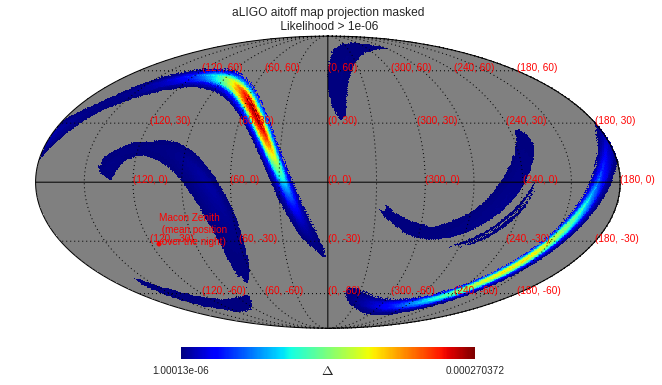

In [27]:
likehood_cut=0.000001 #cut level for mask buildup

aligo_alert_map_high_like = np.logical_not(aligo_banana < likehood_cut)
map_lik_masked = hp.ma(aligo_banana)
map_lik_masked.mask = np.logical_not(aligo_alert_map_high_like)

hp.mollview(map_lik_masked.filled(), 
            title='aLIGO aitoff map projection masked\n Likelihood > {}'.format(likehood_cut),
            unit='$\Delta$', fig=2)
hp.graticule()
hp.projscatter(mean_zenith_ra, zenith_dec
               , lonlat=True, color="red")
hp.projtext(mean_zenith_ra, zenith_dec,
            'Macon Zenith\n (mean position\n over the night)', lonlat=True, color="red")

for ra in range(0,360,60):
    for dec in range(-60,80,30):
        if not (ra == 300 and dec == -30):
            hp.projtext(ra,dec,'({}, {})'.format(ra,dec), lonlat=True, color='red')

plt.savefig(os.path.join(plots, 'allsky_likelihoodmap_masked.png'), dpi=300)
plt.show()

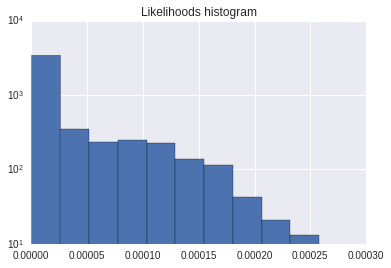

In [28]:
deg2rad = m.pi/180.

phis = list(sample['RA']*deg2rad)
thetas = list(m.pi/2. - sample['DEC']*deg2rad)

def interp_filter(theta, phi):
    return hp.pixelfunc.get_interp_val(aligo_alert_map_high_like, 
                                       theta, phi, nest=False)

def interp(theta, phi):
    return hp.pixelfunc.get_interp_val(aligo_banana, 
                                       theta, phi, nest=False)

interps_filter = np.asarray(map(interp_filter, thetas, phis))

clipped = np.where(interps_filter > 0.2)

interps = np.asarray(map(interp, thetas, phis))

targets = sample[clipped[0]]

target_liks = interps[clipped[0]]

plt.hist(target_liks, log=True)
plt.title('Likelihoods histogram')
plt.show()


In [29]:
targets['Likelihoods'] = target_liks

4801


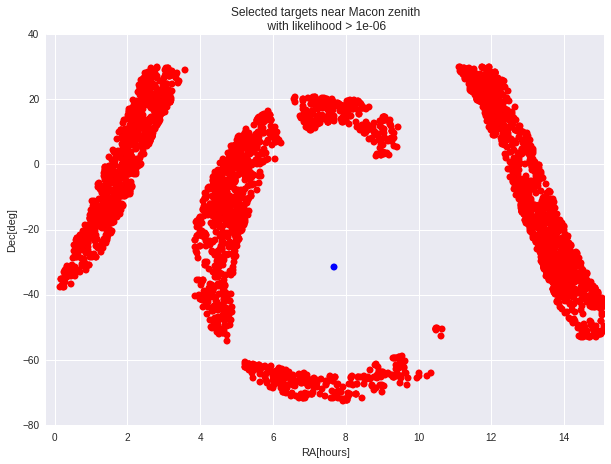

In [30]:
print len(targets)

plt.figure(figsize=(10,7))
plt.rcParams.update({"font.size":12})
plt.plot(targets['RA']/15.,targets['DEC'], "ro")
plt.plot(mean_zenith_ra/15., zenith_dec, 'bo')
plt.xlim(ramin,ramax)
plt.title("Selected targets near Macon zenith\n with likelihood > {}".format(likehood_cut))
plt.xlabel("RA[hours]")
plt.ylabel("Dec[deg]")
#plt.grid()
plt.savefig(os.path.join(plots, "selected_targets_Ra_dec.png"), dpi=300)
plt.show()

4801


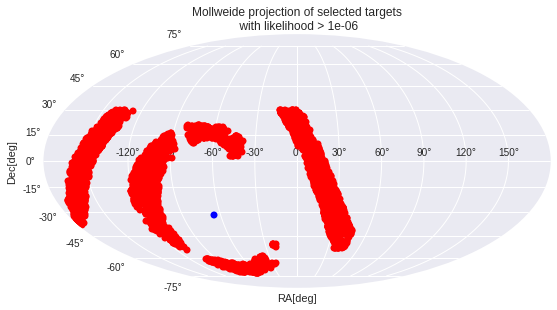

In [31]:
print len(targets)

plt.figure(figsize=(10,10))
plt.subplot(211, projection="mollweide")
deg2rad=m.pi/180.
plt.rcParams.update({"font.size":12})
plt.plot(targets['RA']*deg2rad-m.pi,targets['DEC']*deg2rad, "ro")
plt.plot(mean_zenith_ra*deg2rad-m.pi, zenith_dec*deg2rad, 'bo')
plt.title("Mollweide projection of selected targets\n with likelihood > {}".format(likehood_cut))
plt.xlabel("RA[deg]")
plt.ylabel("Dec[deg]")

plt.savefig(os.path.join(plots,"mollweide_selected_targets.png"), dpi=300)
plt.show()

In [32]:
targets

TMID,RA,DEC,GLON,GLAT,MKC,MHC,MJC,MKTC,MHTC,MJTC,EKC,EHC,EJC,EKTC,EHTC,EJTC,EBV,RISO,RTOT,BA,FLAGS,TYPE,TYPESRC,V,EV,VCAT,VSRC,CATID,Dist,Likelihoods
string128,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,string32,string40,string16,int32,int16,string8,string152,string224,int32,float64
13363905-3357572,204.163,-33.9659,313.538,27.973,7.579,7.832,8.525,7.479,7.728,8.427,0.021,0.013,0.012,0.021,0.013,0.013,0.064,1.898,2.039,0.92,0333,-5,ZC,3737,10,N,2000MNRAS.313..469S,IC_4296,53,7.82354631919e-06
14033877-3358422,210.912,-33.9784,319.625,26.5419,7.705,7.97,8.649,7.492,7.788,8.414,0.019,0.017,0.017,0.032,0.027,0.022,0.073,1.913,2.191,0.81,Z111,-5,ZC,4126,15,N,2003MNRAS.339..652K,NGC_5419,58,0.000145836849969
04313985-0505099,67.9161,-5.08612,200.416,-33.2417,8.128,8.406,9.074,8.026,8.319,8.979,0.02,0.014,0.011,0.019,0.014,0.011,0.043,1.849,1.993,0.74,0000,-5,ZC,4681,8,N,2006MNRAS.370.1213C,NGC_1600,66,5.6697223304e-06
04565634-0451566,74.2347,-4.86575,203.699,-27.6137,8.156,8.417,9.091,8.073,8.304,8.982,0.018,0.011,0.01,0.018,0.011,0.01,0.043,1.766,1.915,0.72,0111,-5,ZC,3891,45,6,20096dF...C...0000J,g0456563-045157,55,7.99537220124e-06
13490531-3017452,207.272,-30.2959,317.444,30.9461,8.184,8.461,9.085,8.034,8.313,8.894,0.028,0.026,0.018,0.026,0.024,0.017,0.06,1.931,2.07,0.6,0000,-3,ZC,4517,31,6,20096dF...C...0000J,g1349053-301745,64,0.000111648825089
12543570-1234070,193.649,-12.5686,304.138,50.2957,8.23,8.489,9.212,8.058,8.324,9.036,0.019,0.017,0.016,0.032,0.023,0.022,0.053,1.806,2.097,0.7,0111,-5,ZC,4618,31,F,20112MRS.FLWO.0000H,12543570-1234070,65,6.72498528456e-06
14155467-4806535,213.978,-48.1148,317.19,12.4045,8.341,8.542,9.246,8.236,8.422,9.109,0.023,0.018,0.016,0.023,0.017,0.016,0.203,1.719,1.872,0.84,0000,-5,JH,4123,20,N,2008AJ....135.2424O,NGC_5516,58,8.78580004568e-06
01562095+0537437,29.0874,5.62887,150.934,-53.6763,8.357,8.64,9.293,8.276,8.508,9.15,0.02,0.019,0.014,0.02,0.02,0.015,0.053,1.782,1.929,0.64,0666,-5,ZC,5561,17,N,1991RC3.9.C...0000d,NGC_0741,79,0.000114350132804
08572051+0255171,134.335,2.9214,225.662,29.1656,8.394,8.661,9.366,8.299,8.531,9.222,0.024,0.016,0.014,0.022,0.015,0.014,0.043,1.789,1.937,0.48,0333,2B3T,ZC,3894,2,S,2011SDSS8.C...0000:,08572050+0255167,55,1.63393964001e-06


Uno puede ahora usar las galaxias (visibles) dentro de la mascara y rankearlas como mas le guste.
Se pueden ordenar simplemente por Likehood por ejemplo, ahora dado que van a estar observando varios
telescopios (quizas conviene acordar quien mira quien) y las mejoras de posteriores de las alertas
cambian el negocio substancialmente ademas del input de nuestras mediciones

In [ ]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import FK5

RAJ2015 = []
DecJ2015 = []
RA = []
Dec = []

for row in targets:
    coord=SkyCoord(ra=row['RA']*u.degree, dec=row['DEC']*u.degree, frame='icrs')
    precessed=coord.transform_to(FK5(equinox='J2015.11'))
    
    RAJ2015.append(precessed.to_string('hmsdms').split()[0])
    DecJ2015.append(precessed.to_string('hmsdms').split()[1])
    
    strcoord = coord.to_string('hmsdms')
    RA.append(strcoord.split()[0])
    Dec.append(strcoord.split()[1])
    #print i, coord.to_string('hmsdms'), targetLik[ind], targetMag[ind], RAJ2015[i], DecJ2015[i], name2[ind]


In [ ]:
targets['RAJ2015'] = RAJ2015
targets['DecJ2015'] = DecJ2015
targets['RAJ2000'] = RA
targets['DecJ2000'] = Dec

In [86]:
#targets.rename_column('App_Mag', 'AppMag')
#targets.rename_column('Abs_Mag', 'AbsMag')
#targets.rename_column('Maj_Diam_a', 'MajDiamA')
#targets.rename_column('Min_Diam_b', 'MinDiamB')
#targets.rename_column('err_Maj_Diam','ErrMajDiam')
#targets.rename_column('err_Min_Diam','ErrMinDiam')
#targets.rename_column('err_Dist', 'ErrDist')
#targets.rename_column('err_App_Mag', 'ErrAppMag')
#targets.rename_column('err_Abs_Mag', 'ErrAbsMag')
#targets.rename_column('err_b/a', 'Errb/a')

In [87]:
targets

TMID,RA,DEC,GLON,GLAT,MKC,MHC,MJC,MKTC,MHTC,MJTC,EKC,EHC,EJC,EKTC,EHTC,EJTC,EBV,RISO,RTOT,BA,FLAGS,TYPE,TYPESRC,V,EV,VCAT,VSRC,CATID,Dist,Likelihoods,RAJ2015,DecJ2015,RAJ2000,DecJ2000
string128,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,string32,string40,string16,int32,int16,string8,string152,string224,int32,float64,unicode448,unicode480,unicode448,unicode480
13363905-3357572,204.163,-33.9659,313.538,27.973,7.579,7.832,8.525,7.479,7.728,8.427,0.021,0.013,0.012,0.021,0.013,0.013,0.064,1.898,2.039,0.92,0333,-5,ZC,3737,10,N,2000MNRAS.313..469S,IC_4296,53,7.82354631919e-06,13h37m31.1083s,-34d02m33.2284s,13h36m39.0454s,-33d57m57.1729s
14033877-3358422,210.912,-33.9784,319.625,26.5419,7.705,7.97,8.649,7.492,7.788,8.414,0.019,0.017,0.017,0.032,0.027,0.022,0.073,1.913,2.191,0.81,Z111,-5,ZC,4126,15,N,2003MNRAS.339..652K,NGC_5419,58,0.000145836849969,14h04m32.2572s,-34d03m01.7065s,14h03m38.7708s,-33d58m42.2031s
04313985-0505099,67.9161,-5.08612,200.416,-33.2417,8.128,8.406,9.074,8.026,8.319,8.979,0.02,0.014,0.011,0.019,0.014,0.011,0.043,1.849,1.993,0.74,0000,-5,ZC,4681,8,N,2006MNRAS.370.1213C,NGC_1600,66,5.6697223304e-06,04h32m24.6645s,-05d03m16.6576s,04h31m39.8621s,-05d05m10.0325s
04565634-0451566,74.2347,-4.86575,203.699,-27.6137,8.156,8.417,9.091,8.073,8.304,8.982,0.018,0.011,0.01,0.018,0.011,0.01,0.043,1.766,1.915,0.72,0111,-5,ZC,3891,45,6,20096dF...C...0000J,g0456563-045157,55,7.99537220124e-06,04h57m41.1486s,-04d50m34.9186s,04h56m56.3361s,-04d51m56.6994s
13490531-3017452,207.272,-30.2959,317.444,30.9461,8.184,8.461,9.085,8.034,8.313,8.894,0.028,0.026,0.018,0.026,0.024,0.017,0.06,1.931,2.07,0.6,0000,-3,ZC,4517,31,6,20096dF...C...0000J,g1349053-301745,64,0.000111648825089,13h49m57.2071s,-30d22m13.9936s,13h49m05.3101s,-30d17m45.097s
12543570-1234070,193.649,-12.5686,304.138,50.2957,8.23,8.489,9.212,8.058,8.324,9.036,0.019,0.017,0.016,0.032,0.023,0.022,0.053,1.806,2.097,0.7,0111,-5,ZC,4618,31,F,20112MRS.FLWO.0000H,12543570-1234070,65,6.72498528456e-06,12h55m23.2353s,-12d39m01.1479s,12h54m35.6982s,-12d34m06.9967s
14155467-4806535,213.978,-48.1148,317.19,12.4045,8.341,8.542,9.246,8.236,8.422,9.109,0.023,0.018,0.016,0.023,0.017,0.016,0.203,1.719,1.872,0.84,0000,-5,JH,4123,20,N,2008AJ....135.2424O,NGC_5516,58,8.78580004568e-06,14h16m53.7958s,-48d11m04.2041s,14h15m54.6936s,-48d06m53.4567s
01562095+0537437,29.0874,5.62887,150.934,-53.6763,8.357,8.64,9.293,8.276,8.508,9.15,0.02,0.019,0.014,0.02,0.02,0.015,0.053,1.782,1.929,0.64,0666,-5,ZC,5561,17,N,1991RC3.9.C...0000d,NGC_0741,79,0.000114350132804,01h57m08.4045s,+05d42m08.3053s,01h56m20.9642s,+05d37m43.932s
08572051+0255171,134.335,2.9214,225.662,29.1656,8.394,8.661,9.366,8.299,8.531,9.222,0.024,0.016,0.014,0.022,0.015,0.014,0.043,1.789,1.937,0.48,0333,2B3T,ZC,3894,2,S,2011SDSS8.C...0000:,08572050+0255167,55,1.63393964001e-06,08h58m07.7032s,+02d51m45.0149s,08h57m20.5115s,+02d55m17.0403s


In [88]:
targets.sort(['Likelihoods'])

In [89]:
targets.reverse()

In [90]:
targets

TMID,RA,DEC,GLON,GLAT,MKC,MHC,MJC,MKTC,MHTC,MJTC,EKC,EHC,EJC,EKTC,EHTC,EJTC,EBV,RISO,RTOT,BA,FLAGS,TYPE,TYPESRC,V,EV,VCAT,VSRC,CATID,Dist,Likelihoods,RAJ2015,DecJ2015,RAJ2000,DecJ2000
string128,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,string32,string40,string16,int32,int16,string8,string152,string224,int32,float64,unicode448,unicode480,unicode448,unicode480
03040117+2945450,46.0049,29.7625,154.476,-24.8677,11.197,11.442,12.198,10.965,11.205,11.974,0.052,0.034,0.028,0.05,0.036,0.033,0.275,1.204,1.511,0.82,0000,0,JH,16187,74,F,20112MRS.FLWO.0000H,03040120+2945450,231,0.000257867699546,03h04m55.9735s,+29d49m14.9663s,03h04m01.1783s,+29d45m45.0714s
03021314+2908284,45.5547,29.1413,154.477,-25.6023,11.641,11.916,12.597,11.364,11.597,12.396,0.05,0.034,0.026,0.064,0.046,0.064,0.209,1.068,1.506,0.82,0000,98,NN,11039,44,F,20112MRS.FLWO.0000H,03021314+2908284,157,0.000251304196771,03h03m07.6631s,+29d12m00.1079s,03h02m13.1378s,+29d08m28.5022s
03074314+2935537,46.9298,29.5983,155.317,-24.5699,11.266,11.54,12.246,11.155,11.289,12.017,0.043,0.03,0.023,0.041,0.028,0.024,0.273,1.083,1.346,0.86,0000,-4,ZC,11056,0,N,1969MSAIt..40..559B,V_Zw_321,157,0.000248539357657,03h08m38.0123s,+29d39m20.3299s,03h07m43.1451s,+29d35m53.9864s
03070763+2929014,46.7817,29.4838,155.267,-24.7362,11.57,11.882,12.597,11.47,11.66,12.428,0.049,0.035,0.028,0.049,0.036,0.032,0.265,1.114,1.367,0.82,0000,98,NN,11300,27,F,20112MRS.FLWO.0000H,03070763+2929014,161,0.000248424849367,03h08m02.416s,+29d32m28.668s,03h07m07.608s,+29d29m01.7519s
03070115+2911514,46.7548,29.1976,155.418,-24.9886,11.226,11.511,12.232,10.945,11.293,11.878,0.052,0.036,0.028,0.054,0.045,0.034,0.246,1.23,1.579,0.68,0000,-5,JH,10996,50,F,20112MRS.FLWO.0000H,03070120+2911500,157,0.000243835749429,03h07m55.8664s,+29d15m18.4883s,03h07m01.1591s,+29d11m51.4677s
03062264+2850325,46.5944,28.8423,155.503,-25.3628,11.324,11.648,12.42,11.227,11.385,12.153,0.041,0.029,0.023,0.039,0.027,0.024,0.219,1.121,1.371,0.44,0000,98,NN,10845,44,F,20112MRS.FLWO.0000H,03062260+2850320,154,0.000238530592391,03h07m17.2129s,+28d53m59.9558s,03h06m22.6465s,+28d50m32.3158s
02460996+2432149,41.5415,24.5374,153.694,-31.393,11.03,11.28,11.999,10.691,10.954,11.585,0.048,0.036,0.025,0.058,0.054,0.035,0.217,1.21,1.622,0.82,0000,-5,ZC,10002,0,N,2001ApJ...560..566K,2MASX_J02460996+2432149,142,0.000237336607531,02h47m02.5582s,+24d36m00.9755s,02h46m09.96s,+24d32m14.713s
02530696+2529252,43.2791,25.4904,154.703,-29.7705,10.099,10.366,11.039,9.932,10.22,10.868,0.035,0.029,0.019,0.031,0.027,0.019,0.117,1.47,1.664,0.78,0311,-3,ZC,6703,4,N,1999PASP..111..438F,IC_1861,95,0.000236312440577,02h54m00.0644s,+25d33m05.4928s,02h53m06.9791s,+25d29m25.4411s
02485937+2630391,42.2473,26.511,153.188,-29.3658,11.517,11.975,12.748,11.336,11.78,12.618,0.043,0.037,0.028,0.047,0.046,0.039,0.16,1.064,1.434,0.7,0000,98,NN,17387,0,N,1995ApJ...449..527L,2MASX_J02485937+2630391,248,0.000235884367458,02h49m52.6204s,+26d34m23.1812s,02h48m59.3619s,+26d30m39.4203s


In [91]:
small_table = targets[0:30]
small_table.sort('RA')

In [98]:
small_table['CATID','Dist','MHC','RAJ2015','DecJ2015'].write('./2MASSsmall_table_targets.txt', format='ascii')

In [96]:
print "Max RA = {}, Min RA = {}".format(targets['RA'].max()/15., targets['RA'].min()/15.)

Max RA = 14.3449788411, Min RA = 0.158379999797


In [97]:
small_table

TMID,RA,DEC,GLON,GLAT,MKC,MHC,MJC,MKTC,MHTC,MJTC,EKC,EHC,EJC,EKTC,EHTC,EJTC,EBV,RISO,RTOT,BA,FLAGS,TYPE,TYPESRC,V,EV,VCAT,VSRC,CATID,Dist,Likelihoods,RAJ2015,DecJ2015,RAJ2000,DecJ2000
string128,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,string32,string40,string16,int32,int16,string8,string152,string224,int32,float64,unicode448,unicode480,unicode448,unicode480
02332448+2016228,38.3521,20.273,153.104,-36.5538,11.03,11.259,11.912,10.604,10.888,11.521,0.06,0.044,0.03,0.074,0.065,0.046,0.118,1.274,1.699,0.72,0000,-4,ZC,8931,36,N,1999ApJS..121..287H,UGC_02031,127,0.000218635067235,02h34m15.6042s,+20d20m19.9921s,02h33m24.494s,+20d16m22.8712s
02340001+2058364,38.5001,20.9768,152.839,-35.869,9.138,9.456,10.133,9.075,9.406,10.041,0.021,0.017,0.013,0.021,0.017,0.014,0.109,1.539,1.711,0.74,0000,4A3T,ZC,4295,5,N,1993AJ....105.1271G,NGC_0976,61,0.000211469797918,02h34m51.3213s,+21d02m33.0055s,02h34m00.0192s,+20d58m36.3734s
02351012+2051052,38.7921,20.8515,153.209,-35.8488,10.99,11.122,11.803,10.408,10.235,11.04,0.082,0.05,0.036,0.094,0.05,0.043,0.132,1.49,1.881,0.3,0000,4X,ZC,4265,4,N,1998A&AS..130..333T,UGC_02064,60,0.000216608866111,02h36m01.4149s,+20d55m00.9199s,02h35m10.1138s,+20d51m05.2542s
02352447+1956283,38.852,19.9412,153.815,-36.6187,11.637,11.983,12.708,11.431,11.621,12.399,0.072,0.053,0.042,0.067,0.048,0.042,0.125,1.294,1.528,0.42,0000,4,ZC,8669,10,N,1993AJ....105.1271G,UGC_02071,123,0.00021314828883,02h36m15.5551s,+20d00m23.8237s,02h35m24.4775s,+19d56m28.3553s
02370209+2025385,39.2588,20.4274,153.935,-36.008,11.459,11.796,12.426,11.39,11.548,12.165,0.053,0.042,0.029,0.053,0.041,0.029,0.126,1.107,1.363,0.74,0000,-4,ZC,9118,0,N,2001ApJ...560..566K,CGCG_462-032,130,0.0002153976318,02h37m53.3535s,+20d29m32.8545s,02h37m02.1121s,+20d25m38.7451s
02371301+2134029,39.3042,21.5676,153.299,-34.9913,10.663,10.936,11.624,10.437,10.702,11.374,0.051,0.041,0.028,0.046,0.039,0.032,0.148,1.428,1.684,0.54,0000,0,ZC,8217,5,N,1993AJ....105.1271G,UGC_02099,117,0.000226942695115,02h38m04.5421s,+21d37m57.1374s,02h37m13.0032s,+21d34m03.1824s
02372549+2106030,39.3562,21.1008,153.628,-35.3758,9.786,10.113,10.844,9.744,10.058,10.773,0.021,0.019,0.014,0.02,0.02,0.016,0.149,1.433,1.618,0.54,0000,5B_P,ZC,4141,4,N,1991RC3.9.C...0000d,NGC_0992,59,0.000222718851409,02h38m16.9094s,+21d09m56.6596s,02h37m25.4855s,+21d06m02.8784s
02404997+2136338,40.2082,21.6094,154.166,-34.5428,10.458,10.749,11.482,10.361,10.643,11.304,0.027,0.027,0.019,0.031,0.027,0.027,0.172,1.42,1.631,0.28,0000,2,ZC,7975,10,N,1993AJ....105.1271G,CGCG_462-042,113,0.00022180558683,02h41m41.6243s,+21d40m24.6962s,02h40m49.9777s,+21d36m33.8049s
02422488+2443568,40.6036,24.7325,152.712,-31.6442,11.72,12.003,12.721,11.506,11.789,12.592,0.069,0.058,0.041,0.067,0.063,0.051,0.245,1.143,1.405,0.66,0000,98,NN,14127,38,F,20112MRS.FLWO.0000H,02422488+2443568,201,0.00021879979268,02h43m17.4146s,+24d47m46.3832s,02h42m24.8758s,+24d43m56.8561s


I am going to calculate how many objects we will be able to visit, and assume that we have only capability to cover 3 objects per hour.

After that the next step is to make fringe selections and rankings per fringe by Likelihood.

In [75]:
deltaRA = targets['RA'].max() - targets['RA'].min()

estimated_N_objects = deltaRA*3. 

print "The maximum number of objects visitable are {}".format(round(estimated_N_objects))

The maximum number of objects visitable are 42.0


So we choose the above number of objects to work. 

The idea will be to optimize the objects using as primary variable the likelihood, and as a second determiner the sky position. And to achieve this *I will try* to use linked lists to target double or triple objects first.

In [70]:
import link as ll

ImportError: No module named link

In [71]:
near_filter = targets['Dist']<35.
near_targets= targets[near_filter]

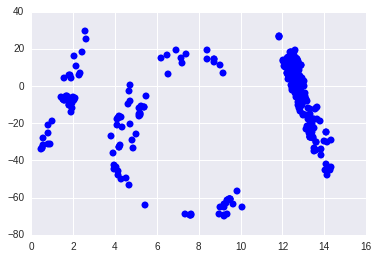

In [72]:
plt.plot(near_targets['RA'], near_targets['Dec'], 'bo')
plt.show()

In [73]:
near_targets.sort('Likelihoods')

In [74]:
plt.plot(far_away['RAJ2000'], far_away['Likelihood'], 'bo')
plt.xlabel('RA')
plt.ylabel('Likelihood')
for source in far_away:
    plt.Annotation(s=source['Name'], xy=(source['RAJ2000'], source['Likelihood']), xycoords='data')
#plt.Annotation(s='hola', xy=(5,0.001), xycoords='data')
plt.show()

NameError: name 'far_away' is not defined

In [ ]:
far_away.reverse()

In [ ]:
far_away

In [ ]:

plt.figure(figsize=(14,9))
plt.scatter(np.asarray(far_away['RAJ2000']), np.asarray(far_away['DecJ2000']), s=2E11*far_away['Likelihood']**2., 
            c=far_away['Likelihood'])
plt.xlabel('RAJ2000')
plt.ylabel('DecJ2000')
plt.show()

In [ ]:
a_hi = far_away['RAJ2000']<7.
a_lo = far_away['RAJ2000']>0.5
secbin= far_away[a_hi & a_lo]
lik = secbin['Likelihood']

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(np.asarray(secbin['RAJ2000']), np.asarray(secbin['DecJ2000']), s=2E11*secbin['Likelihood']**2., 
            c=secbin['Likelihood'])
for goodies in range(3):
    row = secbin[goodies]
    plt.annotate(s=str(row['Name']), xy=(row['RAJ2000'], row['DecJ2000']))

plt.xlabel('RAJ2000')
plt.ylabel('DecJ2000')
plt.show()

In [ ]:
aaa = SkyCoord(ra=secbin[7]['RAJ2000']*u.hourangle, dec=secbin[7]['DecJ2000']*u.degree)
aaa.to_string('hmsdms')

In [ ]:
bbb = SkyCoord(ra=secbin[0]['RAJ2000']*u.hourangle, dec=secbin[0]['DecJ2000']*u.degree)
bbb.to_string('hmsdms')

In [ ]:
b_hi = candidates['RAJ2000']<7.5
b_lo = candidates['RAJ2000']>5.5
dist_lo = candidates['Distance']>35.
mag_hi = candidates['Appmag']< 17.
thirdbin= candidates[b_hi & b_lo & mag_hi & dist_lo]
thirdbin.sort('Likelihood')

In [ ]:
bbb = SkyCoord(ra=thirdbin[1]['RAJ2000']*u.hourangle, dec=thirdbin[1]['DecJ2000']*u.degree)
bbb.to_string('hmsdms')

In [ ]:
thirdbin

In [ ]:
SkyCoord

In [ ]:
targets.write(os.path.join(plots,'targets_textable.tex'), format='latex')